In [1]:
import os
import os.path
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
import matplotlib.pyplot as plt
import matplotlib.cm as colormap
%matplotlib inline

import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D

Using TensorFlow backend.


In [2]:
imagedir = "Dataset_4850"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.jpg'))  # assuming the images are stored as 'jpg'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.jpg'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:              CG	Number of images: 4850
Label: 1	Family:              PG	Number of images: 4850
Processing images ...
Images processed: 9700


In [4]:
X.shape

(9700, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (ResNet50 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = ResNet50(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [7]:
filename = 'paper-resnet50features-avgpool.npy'
if os.path.exists(filename):
    print("Loading ResNet50 extracted features from %s ..." %(filename))
    resnet50features = np.load(filename)
else:
    print("Extracting features from ResNet50 layers ...")
    resnet50features = base_model.predict(X)
    print("Saving ResNet50 extracted features into %s ..." %(filename))
    np.save(filename, resnet50features)

Loading ResNet50 extracted features from paper-resnet50features-avgpool.npy ...


In [8]:
resnet50features.shape

(9700, 2048)

In [9]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [10]:
# Training top_model and saving min training loss weights
num_epochs=2000
history = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
early_stopping = EarlyStopping(verbose=1, patience=20, monitor='val_loss')
checkpointer = ModelCheckpoint(filepath='cg-top-weights-min_loss-mlp-resnet50-Adam-2000epochs.h5', monitor='loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min')
callbacks_list = [early_stopping, checkpointer]
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = resnet50features[train_indices]
    Y_train = Y[train_indices]
    X_test = resnet50features[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]

    top_input = Input(shape=resnet50features.shape[1:])
    predict = Dense(num_classes, activation='softmax', name='predictions')(top_input)
    top_model = Model(input=top_input, output=predict)                            
    top_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    h = top_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=X_train.shape[0], verbose=1, callbacks=callbacks_list)
    history.append(h)
    
    y_prob = top_model.predict(X_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f" %(i,accuracy_score(y_test,y_pred)))
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("pr..., inputs=Tensor("in...)`


Train on 8730 samples, validate on 970 samples
Epoch 1/2000
8730/8730 [==============================] - 0s - loss: 0.9389 - acc: 0.4876 - val_loss: 0.7957 - val_acc: 0.5619
Epoch 2/2000
8730/8730 [==============================] - 0s - loss: 0.8128 - acc: 0.5621 - val_loss: 0.6963 - val_acc: 0.6196
Epoch 3/2000
8730/8730 [==============================] - 0s - loss: 0.7088 - acc: 0.6088 - val_loss: 0.6236 - val_acc: 0.6701
Epoch 4/2000
8730/8730 [==============================] - 0s - loss: 0.6335 - acc: 0.6655 - val_loss: 0.5627 - val_acc: 0.7134
Epoch 5/2000
8730/8730 [==============================] - 0s - loss: 0.5718 - acc: 0.7100 - val_loss: 0.5184 - val_acc: 0.7495
Epoch 6/2000
8730/8730 [==============================] - 0s - loss: 0.5273 - acc: 0.7419 - val_loss: 0.4859 - val_acc: 0.7649
Epoch 7/2000
8730/8730 [==============================] - 0s - loss: 0.4941 - acc: 0.7645 - val_loss: 0.4601 - val_acc: 0.7907
Epoch 8/2000
8730/8730 [==============================] - 0s - l

8730/8730 [==============================] - 0s - loss: 0.2024 - acc: 0.9208 - val_loss: 0.2369 - val_acc: 0.8979
Epoch 65/2000
8730/8730 [==============================] - 0s - loss: 0.2012 - acc: 0.9213 - val_loss: 0.2361 - val_acc: 0.9000
Epoch 66/2000
8730/8730 [==============================] - 0s - loss: 0.2000 - acc: 0.9226 - val_loss: 0.2353 - val_acc: 0.9021
Epoch 67/2000
8730/8730 [==============================] - 0s - loss: 0.1989 - acc: 0.9231 - val_loss: 0.2345 - val_acc: 0.9021
Epoch 68/2000
8730/8730 [==============================] - 0s - loss: 0.1978 - acc: 0.9235 - val_loss: 0.2337 - val_acc: 0.9031
Epoch 69/2000
8730/8730 [==============================] - 0s - loss: 0.1966 - acc: 0.9241 - val_loss: 0.2329 - val_acc: 0.9031
Epoch 70/2000
8730/8730 [==============================] - 0s - loss: 0.1956 - acc: 0.9246 - val_loss: 0.2321 - val_acc: 0.9031
Epoch 71/2000
8730/8730 [==============================] - 0s - loss: 0.1945 - acc: 0.9252 - val_loss: 0.2314 - val_ac

8730/8730 [==============================] - 0s - loss: 0.1531 - acc: 0.9435 - val_loss: 0.2068 - val_acc: 0.9103
Epoch 128/2000
8730/8730 [==============================] - 0s - loss: 0.1526 - acc: 0.9439 - val_loss: 0.2065 - val_acc: 0.9103
Epoch 129/2000
8730/8730 [==============================] - 0s - loss: 0.1520 - acc: 0.9439 - val_loss: 0.2062 - val_acc: 0.9103
Epoch 130/2000
8730/8730 [==============================] - 0s - loss: 0.1515 - acc: 0.9443 - val_loss: 0.2060 - val_acc: 0.9103
Epoch 131/2000
8730/8730 [==============================] - 0s - loss: 0.1510 - acc: 0.9444 - val_loss: 0.2058 - val_acc: 0.9103
Epoch 132/2000
8730/8730 [==============================] - 0s - loss: 0.1505 - acc: 0.9448 - val_loss: 0.2055 - val_acc: 0.9103
Epoch 133/2000
8730/8730 [==============================] - 0s - loss: 0.1500 - acc: 0.9450 - val_loss: 0.2053 - val_acc: 0.9103
Epoch 134/2000
8730/8730 [==============================] - 0s - loss: 0.1495 - acc: 0.9455 - val_loss: 0.2050 -

8730/8730 [==============================] - 0s - loss: 0.1271 - acc: 0.9551 - val_loss: 0.1960 - val_acc: 0.9103
Epoch 191/2000
8730/8730 [==============================] - 0s - loss: 0.1268 - acc: 0.9552 - val_loss: 0.1959 - val_acc: 0.9113
Epoch 192/2000
8730/8730 [==============================] - 0s - loss: 0.1265 - acc: 0.9556 - val_loss: 0.1958 - val_acc: 0.9124
Epoch 193/2000
8730/8730 [==============================] - 0s - loss: 0.1262 - acc: 0.9558 - val_loss: 0.1957 - val_acc: 0.9124
Epoch 194/2000
8730/8730 [==============================] - 0s - loss: 0.1259 - acc: 0.9558 - val_loss: 0.1956 - val_acc: 0.9124
Epoch 195/2000
8730/8730 [==============================] - 0s - loss: 0.1255 - acc: 0.9558 - val_loss: 0.1955 - val_acc: 0.9124
Epoch 196/2000
8730/8730 [==============================] - 0s - loss: 0.1252 - acc: 0.9559 - val_loss: 0.1954 - val_acc: 0.9124
Epoch 197/2000
8730/8730 [==============================] - 0s - loss: 0.1249 - acc: 0.9561 - val_loss: 0.1953 -

8730/8730 [==============================] - 0s - loss: 0.1101 - acc: 0.9637 - val_loss: 0.1921 - val_acc: 0.9206
Epoch 254/2000
8730/8730 [==============================] - 0s - loss: 0.1098 - acc: 0.9637 - val_loss: 0.1920 - val_acc: 0.9206
Epoch 255/2000
8730/8730 [==============================] - 0s - loss: 0.1096 - acc: 0.9637 - val_loss: 0.1920 - val_acc: 0.9206
Epoch 256/2000
8730/8730 [==============================] - 0s - loss: 0.1094 - acc: 0.9638 - val_loss: 0.1920 - val_acc: 0.9206
Epoch 257/2000
8730/8730 [==============================] - 0s - loss: 0.1092 - acc: 0.9639 - val_loss: 0.1920 - val_acc: 0.9206
Epoch 258/2000
8730/8730 [==============================] - 0s - loss: 0.1089 - acc: 0.9640 - val_loss: 0.1919 - val_acc: 0.9206
Epoch 259/2000
8730/8730 [==============================] - 0s - loss: 0.1087 - acc: 0.9641 - val_loss: 0.1919 - val_acc: 0.9206
Epoch 260/2000
8730/8730 [==============================] - 0s - loss: 0.1085 - acc: 0.9643 - val_loss: 0.1919 -

8730/8730 [==============================] - 0s - loss: 0.5190 - acc: 0.7549 - val_loss: 0.4979 - val_acc: 0.7629
Epoch 7/2000
8730/8730 [==============================] - 0s - loss: 0.4907 - acc: 0.7753 - val_loss: 0.4672 - val_acc: 0.7928
Epoch 8/2000
8730/8730 [==============================] - 0s - loss: 0.4647 - acc: 0.7899 - val_loss: 0.4409 - val_acc: 0.7979
Epoch 9/2000
8730/8730 [==============================] - 0s - loss: 0.4439 - acc: 0.7974 - val_loss: 0.4207 - val_acc: 0.8093
Epoch 10/2000
8730/8730 [==============================] - 0s - loss: 0.4283 - acc: 0.8058 - val_loss: 0.4035 - val_acc: 0.8175
Epoch 11/2000
8730/8730 [==============================] - 0s - loss: 0.4135 - acc: 0.8162 - val_loss: 0.3888 - val_acc: 0.8299
Epoch 12/2000
8730/8730 [==============================] - 0s - loss: 0.3992 - acc: 0.8268 - val_loss: 0.3774 - val_acc: 0.8412
Epoch 13/2000
8730/8730 [==============================] - 0s - loss: 0.3871 - acc: 0.8317 - val_loss: 0.3672 - val_acc: 

8730/8730 [==============================] - 0s - loss: 0.1992 - acc: 0.9243 - val_loss: 0.2211 - val_acc: 0.9144
Epoch 71/2000
8730/8730 [==============================] - 0s - loss: 0.1981 - acc: 0.9246 - val_loss: 0.2204 - val_acc: 0.9134
Epoch 72/2000
8730/8730 [==============================] - 0s - loss: 0.1971 - acc: 0.9250 - val_loss: 0.2197 - val_acc: 0.9134
Epoch 73/2000
8730/8730 [==============================] - 0s - loss: 0.1961 - acc: 0.9257 - val_loss: 0.2192 - val_acc: 0.9155
Epoch 74/2000
8730/8730 [==============================] - 0s - loss: 0.1951 - acc: 0.9254 - val_loss: 0.2186 - val_acc: 0.9155
Epoch 75/2000
8730/8730 [==============================] - 0s - loss: 0.1941 - acc: 0.9258 - val_loss: 0.2180 - val_acc: 0.9155
Epoch 76/2000
8730/8730 [==============================] - 0s - loss: 0.1931 - acc: 0.9261 - val_loss: 0.2174 - val_acc: 0.9165
Epoch 77/2000
8730/8730 [==============================] - 0s - loss: 0.1922 - acc: 0.9265 - val_loss: 0.2167 - val_ac

8730/8730 [==============================] - 0s - loss: 0.1540 - acc: 0.9460 - val_loss: 0.1964 - val_acc: 0.9320
Epoch 134/2000
8730/8730 [==============================] - 0s - loss: 0.1535 - acc: 0.9466 - val_loss: 0.1962 - val_acc: 0.9309
Epoch 135/2000
8730/8730 [==============================] - 0s - loss: 0.1530 - acc: 0.9467 - val_loss: 0.1960 - val_acc: 0.9309
Epoch 136/2000
8730/8730 [==============================] - 0s - loss: 0.1525 - acc: 0.9471 - val_loss: 0.1958 - val_acc: 0.9309
Epoch 137/2000
8730/8730 [==============================] - 0s - loss: 0.1520 - acc: 0.9472 - val_loss: 0.1956 - val_acc: 0.9309
Epoch 138/2000
8730/8730 [==============================] - 0s - loss: 0.1515 - acc: 0.9478 - val_loss: 0.1954 - val_acc: 0.9309
Epoch 139/2000
8730/8730 [==============================] - 0s - loss: 0.1510 - acc: 0.9479 - val_loss: 0.1952 - val_acc: 0.9309
Epoch 140/2000
8730/8730 [==============================] - 0s - loss: 0.1505 - acc: 0.9480 - val_loss: 0.1950 -

8730/8730 [==============================] - 0s - loss: 0.1288 - acc: 0.9577 - val_loss: 0.1878 - val_acc: 0.9289
Epoch 197/2000
8730/8730 [==============================] - 0s - loss: 0.1284 - acc: 0.9576 - val_loss: 0.1877 - val_acc: 0.9289
Epoch 198/2000
8730/8730 [==============================] - 0s - loss: 0.1281 - acc: 0.9577 - val_loss: 0.1877 - val_acc: 0.9289
Epoch 199/2000
8730/8730 [==============================] - 0s - loss: 0.1278 - acc: 0.9580 - val_loss: 0.1876 - val_acc: 0.9289
Epoch 200/2000
8730/8730 [==============================] - 0s - loss: 0.1275 - acc: 0.9582 - val_loss: 0.1875 - val_acc: 0.9289
Epoch 201/2000
8730/8730 [==============================] - 0s - loss: 0.1272 - acc: 0.9582 - val_loss: 0.1874 - val_acc: 0.9289
Epoch 202/2000
8730/8730 [==============================] - 0s - loss: 0.1269 - acc: 0.9583 - val_loss: 0.1874 - val_acc: 0.9289
Epoch 203/2000
8730/8730 [==============================] - 0s - loss: 0.1266 - acc: 0.9584 - val_loss: 0.1873 -

8730/8730 [==============================] - 0s - loss: 0.1118 - acc: 0.9647 - val_loss: 0.1851 - val_acc: 0.9299
Epoch 260/2000
8730/8730 [==============================] - 0s - loss: 0.1116 - acc: 0.9649 - val_loss: 0.1851 - val_acc: 0.9299
Epoch 261/2000
8730/8730 [==============================] - 0s - loss: 0.1114 - acc: 0.9652 - val_loss: 0.1851 - val_acc: 0.9299
Epoch 262/2000
8730/8730 [==============================] - 0s - loss: 0.1111 - acc: 0.9651 - val_loss: 0.1850 - val_acc: 0.9309
Epoch 263/2000
8730/8730 [==============================] - 0s - loss: 0.1109 - acc: 0.9652 - val_loss: 0.1850 - val_acc: 0.9309
Epoch 264/2000
8730/8730 [==============================] - 0s - loss: 0.1107 - acc: 0.9653 - val_loss: 0.1850 - val_acc: 0.9309
Epoch 265/2000
8730/8730 [==============================] - 0s - loss: 0.1105 - acc: 0.9653 - val_loss: 0.1850 - val_acc: 0.9309
Epoch 266/2000
8730/8730 [==============================] - 0s - loss: 0.1103 - acc: 0.9654 - val_loss: 0.1850 -

8730/8730 [==============================] - 0s - loss: 0.3951 - acc: 0.8281 - val_loss: 0.3902 - val_acc: 0.8289
Epoch 20/2000
8730/8730 [==============================] - 0s - loss: 0.3876 - acc: 0.8331 - val_loss: 0.3875 - val_acc: 0.8320
Epoch 21/2000
8730/8730 [==============================] - 0s - loss: 0.3824 - acc: 0.8352 - val_loss: 0.3837 - val_acc: 0.8330
Epoch 22/2000
8730/8730 [==============================] - 0s - loss: 0.3769 - acc: 0.8377 - val_loss: 0.3774 - val_acc: 0.8340
Epoch 23/2000
8730/8730 [==============================] - 0s - loss: 0.3699 - acc: 0.8400 - val_loss: 0.3695 - val_acc: 0.8330
Epoch 24/2000
8730/8730 [==============================] - 0s - loss: 0.3621 - acc: 0.8447 - val_loss: 0.3618 - val_acc: 0.8361
Epoch 25/2000
8730/8730 [==============================] - 0s - loss: 0.3551 - acc: 0.8470 - val_loss: 0.3558 - val_acc: 0.8392
Epoch 26/2000
8730/8730 [==============================] - 0s - loss: 0.3498 - acc: 0.8493 - val_loss: 0.3510 - val_ac

8730/8730 [==============================] - 0s - loss: 0.2250 - acc: 0.9093 - val_loss: 0.2413 - val_acc: 0.8990
Epoch 84/2000
8730/8730 [==============================] - 0s - loss: 0.2240 - acc: 0.9096 - val_loss: 0.2406 - val_acc: 0.8990
Epoch 85/2000
8730/8730 [==============================] - 0s - loss: 0.2230 - acc: 0.9101 - val_loss: 0.2399 - val_acc: 0.8990
Epoch 86/2000
8730/8730 [==============================] - 0s - loss: 0.2220 - acc: 0.9107 - val_loss: 0.2392 - val_acc: 0.8990
Epoch 87/2000
8730/8730 [==============================] - 0s - loss: 0.2210 - acc: 0.9110 - val_loss: 0.2385 - val_acc: 0.9010
Epoch 88/2000
8730/8730 [==============================] - 0s - loss: 0.2201 - acc: 0.9115 - val_loss: 0.2377 - val_acc: 0.9000
Epoch 89/2000
8730/8730 [==============================] - 0s - loss: 0.2191 - acc: 0.9119 - val_loss: 0.2370 - val_acc: 0.9000
Epoch 90/2000
8730/8730 [==============================] - 0s - loss: 0.2182 - acc: 0.9124 - val_loss: 0.2363 - val_ac

8730/8730 [==============================] - 0s - loss: 0.1802 - acc: 0.9315 - val_loss: 0.2119 - val_acc: 0.9134
Epoch 147/2000
8730/8730 [==============================] - 0s - loss: 0.1797 - acc: 0.9318 - val_loss: 0.2116 - val_acc: 0.9134
Epoch 148/2000
8730/8730 [==============================] - 0s - loss: 0.1792 - acc: 0.9321 - val_loss: 0.2113 - val_acc: 0.9134
Epoch 149/2000
8730/8730 [==============================] - 0s - loss: 0.1787 - acc: 0.9322 - val_loss: 0.2111 - val_acc: 0.9144
Epoch 150/2000
8730/8730 [==============================] - 0s - loss: 0.1782 - acc: 0.9324 - val_loss: 0.2108 - val_acc: 0.9144
Epoch 151/2000
8730/8730 [==============================] - 0s - loss: 0.1777 - acc: 0.9330 - val_loss: 0.2105 - val_acc: 0.9144
Epoch 152/2000
8730/8730 [==============================] - 0s - loss: 0.1772 - acc: 0.9337 - val_loss: 0.2102 - val_acc: 0.9144
Epoch 153/2000
8730/8730 [==============================] - 0s - loss: 0.1767 - acc: 0.9336 - val_loss: 0.2099 -

8730/8730 [==============================] - 0s - loss: 0.1544 - acc: 0.9431 - val_loss: 0.1984 - val_acc: 0.9175
Epoch 210/2000
8730/8730 [==============================] - 0s - loss: 0.1541 - acc: 0.9432 - val_loss: 0.1982 - val_acc: 0.9175
Epoch 211/2000
8730/8730 [==============================] - 0s - loss: 0.1538 - acc: 0.9433 - val_loss: 0.1981 - val_acc: 0.9175
Epoch 212/2000
8730/8730 [==============================] - 0s - loss: 0.1534 - acc: 0.9435 - val_loss: 0.1979 - val_acc: 0.9175
Epoch 213/2000
8730/8730 [==============================] - 0s - loss: 0.1531 - acc: 0.9441 - val_loss: 0.1978 - val_acc: 0.9175
Epoch 214/2000
8730/8730 [==============================] - 0s - loss: 0.1528 - acc: 0.9441 - val_loss: 0.1976 - val_acc: 0.9175
Epoch 215/2000
8730/8730 [==============================] - 0s - loss: 0.1525 - acc: 0.9443 - val_loss: 0.1975 - val_acc: 0.9175
Epoch 216/2000
8730/8730 [==============================] - 0s - loss: 0.1521 - acc: 0.9443 - val_loss: 0.1973 -

8730/8730 [==============================] - 0s - loss: 0.1366 - acc: 0.9507 - val_loss: 0.1910 - val_acc: 0.9237
Epoch 273/2000
8730/8730 [==============================] - 0s - loss: 0.1364 - acc: 0.9510 - val_loss: 0.1909 - val_acc: 0.9237
Epoch 274/2000
8730/8730 [==============================] - 0s - loss: 0.1361 - acc: 0.9510 - val_loss: 0.1908 - val_acc: 0.9227
Epoch 275/2000
8730/8730 [==============================] - 0s - loss: 0.1359 - acc: 0.9511 - val_loss: 0.1907 - val_acc: 0.9227
Epoch 276/2000
8730/8730 [==============================] - 0s - loss: 0.1356 - acc: 0.9512 - val_loss: 0.1906 - val_acc: 0.9227
Epoch 277/2000
8730/8730 [==============================] - 0s - loss: 0.1354 - acc: 0.9512 - val_loss: 0.1905 - val_acc: 0.9227
Epoch 278/2000
8730/8730 [==============================] - 0s - loss: 0.1352 - acc: 0.9513 - val_loss: 0.1905 - val_acc: 0.9227
Epoch 279/2000
8730/8730 [==============================] - 0s - loss: 0.1349 - acc: 0.9513 - val_loss: 0.1904 -

8730/8730 [==============================] - 0s - loss: 0.1232 - acc: 0.9573 - val_loss: 0.1868 - val_acc: 0.9278
Epoch 336/2000
8730/8730 [==============================] - 0s - loss: 0.1230 - acc: 0.9573 - val_loss: 0.1867 - val_acc: 0.9278
Epoch 337/2000
8730/8730 [==============================] - 0s - loss: 0.1228 - acc: 0.9573 - val_loss: 0.1867 - val_acc: 0.9278
Epoch 338/2000
8730/8730 [==============================] - 0s - loss: 0.1226 - acc: 0.9574 - val_loss: 0.1866 - val_acc: 0.9278
Epoch 339/2000
8730/8730 [==============================] - 0s - loss: 0.1224 - acc: 0.9574 - val_loss: 0.1866 - val_acc: 0.9289
Epoch 340/2000
8730/8730 [==============================] - 0s - loss: 0.1223 - acc: 0.9574 - val_loss: 0.1865 - val_acc: 0.9299
Epoch 341/2000
8730/8730 [==============================] - 0s - loss: 0.1221 - acc: 0.9574 - val_loss: 0.1865 - val_acc: 0.9299
Epoch 342/2000
8730/8730 [==============================] - 0s - loss: 0.1219 - acc: 0.9576 - val_loss: 0.1864 -

8730/8730 [==============================] - 0s - loss: 0.1125 - acc: 0.9631 - val_loss: 0.1846 - val_acc: 0.9330
Epoch 399/2000
8730/8730 [==============================] - 0s - loss: 0.1124 - acc: 0.9632 - val_loss: 0.1846 - val_acc: 0.9330
Epoch 400/2000
8730/8730 [==============================] - 0s - loss: 0.1122 - acc: 0.9632 - val_loss: 0.1845 - val_acc: 0.9330
Epoch 401/2000
8730/8730 [==============================] - 0s - loss: 0.1121 - acc: 0.9632 - val_loss: 0.1845 - val_acc: 0.9330
Epoch 402/2000
8730/8730 [==============================] - 0s - loss: 0.1119 - acc: 0.9632 - val_loss: 0.1845 - val_acc: 0.9330
Epoch 403/2000
8730/8730 [==============================] - 0s - loss: 0.1118 - acc: 0.9636 - val_loss: 0.1845 - val_acc: 0.9330
Epoch 404/2000
8730/8730 [==============================] - 0s - loss: 0.1116 - acc: 0.9636 - val_loss: 0.1845 - val_acc: 0.9340
Epoch 405/2000
8730/8730 [==============================] - 0s - loss: 0.1115 - acc: 0.9637 - val_loss: 0.1844 -

8730/8730 [==============================] - 0s - loss: 0.1038 - acc: 0.9670 - val_loss: 0.1838 - val_acc: 0.9330
Epoch 462/2000
8730/8730 [==============================] - 0s - loss: 0.1036 - acc: 0.9671 - val_loss: 0.1838 - val_acc: 0.9340
Epoch 463/2000
8730/8730 [==============================] - 0s - loss: 0.1035 - acc: 0.9672 - val_loss: 0.1838 - val_acc: 0.9340
Epoch 464/2000
8730/8730 [==============================] - 0s - loss: 0.1034 - acc: 0.9672 - val_loss: 0.1838 - val_acc: 0.9340
Epoch 465/2000
8730/8730 [==============================] - 0s - loss: 0.1032 - acc: 0.9672 - val_loss: 0.1838 - val_acc: 0.9340
Epoch 466/2000
8730/8730 [==============================] - 0s - loss: 0.1031 - acc: 0.9672 - val_loss: 0.1838 - val_acc: 0.9340
Epoch 467/2000
8730/8730 [==============================] - 0s - loss: 0.1030 - acc: 0.9672 - val_loss: 0.1838 - val_acc: 0.9340
Epoch 468/2000
8730/8730 [==============================] - 0s - loss: 0.1029 - acc: 0.9672 - val_loss: 0.1838 -

8730/8730 [==============================] - 0s - loss: 0.2926 - acc: 0.8773 - val_loss: 0.2916 - val_acc: 0.8804
Epoch 31/2000
8730/8730 [==============================] - 0s - loss: 0.2890 - acc: 0.8789 - val_loss: 0.2891 - val_acc: 0.8814
Epoch 32/2000
8730/8730 [==============================] - 0s - loss: 0.2857 - acc: 0.8808 - val_loss: 0.2865 - val_acc: 0.8825
Epoch 33/2000
8730/8730 [==============================] - 0s - loss: 0.2823 - acc: 0.8824 - val_loss: 0.2839 - val_acc: 0.8814
Epoch 34/2000
8730/8730 [==============================] - 0s - loss: 0.2790 - acc: 0.8840 - val_loss: 0.2817 - val_acc: 0.8845
Epoch 35/2000
8730/8730 [==============================] - 0s - loss: 0.2759 - acc: 0.8855 - val_loss: 0.2799 - val_acc: 0.8876
Epoch 36/2000
8730/8730 [==============================] - 0s - loss: 0.2732 - acc: 0.8872 - val_loss: 0.2782 - val_acc: 0.8866
Epoch 37/2000
8730/8730 [==============================] - 0s - loss: 0.2706 - acc: 0.8885 - val_loss: 0.2765 - val_ac

8730/8730 [==============================] - 0s - loss: 0.1899 - acc: 0.9261 - val_loss: 0.2382 - val_acc: 0.9103
Epoch 95/2000
8730/8730 [==============================] - 0s - loss: 0.1891 - acc: 0.9265 - val_loss: 0.2379 - val_acc: 0.9103
Epoch 96/2000
8730/8730 [==============================] - 0s - loss: 0.1884 - acc: 0.9263 - val_loss: 0.2375 - val_acc: 0.9103
Epoch 97/2000
8730/8730 [==============================] - 0s - loss: 0.1876 - acc: 0.9265 - val_loss: 0.2372 - val_acc: 0.9103
Epoch 98/2000
8730/8730 [==============================] - 0s - loss: 0.1868 - acc: 0.9265 - val_loss: 0.2368 - val_acc: 0.9113
Epoch 99/2000
8730/8730 [==============================] - 0s - loss: 0.1861 - acc: 0.9269 - val_loss: 0.2365 - val_acc: 0.9113
Epoch 100/2000
8730/8730 [==============================] - 0s - loss: 0.1854 - acc: 0.9271 - val_loss: 0.2362 - val_acc: 0.9113
Epoch 101/2000
8730/8730 [==============================] - 0s - loss: 0.1846 - acc: 0.9278 - val_loss: 0.2360 - val_

8730/8730 [==============================] - 0s - loss: 0.1536 - acc: 0.9436 - val_loss: 0.2255 - val_acc: 0.9103
Epoch 158/2000
8730/8730 [==============================] - 0s - loss: 0.1532 - acc: 0.9441 - val_loss: 0.2253 - val_acc: 0.9103
Epoch 159/2000
8730/8730 [==============================] - 0s - loss: 0.1527 - acc: 0.9443 - val_loss: 0.2252 - val_acc: 0.9103
Epoch 160/2000
8730/8730 [==============================] - 0s - loss: 0.1523 - acc: 0.9444 - val_loss: 0.2251 - val_acc: 0.9103
Epoch 161/2000
8730/8730 [==============================] - 0s - loss: 0.1519 - acc: 0.9447 - val_loss: 0.2250 - val_acc: 0.9103
Epoch 162/2000
8730/8730 [==============================] - 0s - loss: 0.1515 - acc: 0.9452 - val_loss: 0.2249 - val_acc: 0.9103
Epoch 163/2000
8730/8730 [==============================] - 0s - loss: 0.1511 - acc: 0.9456 - val_loss: 0.2248 - val_acc: 0.9103
Epoch 164/2000
8730/8730 [==============================] - 0s - loss: 0.1506 - acc: 0.9459 - val_loss: 0.2247 -

8730/8730 [==============================] - 0s - loss: 0.1313 - acc: 0.9540 - val_loss: 0.2211 - val_acc: 0.9134
Epoch 221/2000
8730/8730 [==============================] - 0s - loss: 0.1310 - acc: 0.9542 - val_loss: 0.2211 - val_acc: 0.9134
Epoch 222/2000
8730/8730 [==============================] - 0s - loss: 0.1308 - acc: 0.9542 - val_loss: 0.2211 - val_acc: 0.9144
Epoch 223/2000
8730/8730 [==============================] - 0s - loss: 0.1305 - acc: 0.9542 - val_loss: 0.2210 - val_acc: 0.9144
Epoch 224/2000
8730/8730 [==============================] - 0s - loss: 0.1302 - acc: 0.9542 - val_loss: 0.2210 - val_acc: 0.9144
Epoch 225/2000
8730/8730 [==============================] - 0s - loss: 0.1299 - acc: 0.9543 - val_loss: 0.2210 - val_acc: 0.9144
Epoch 226/2000
8730/8730 [==============================] - 0s - loss: 0.1296 - acc: 0.9544 - val_loss: 0.2210 - val_acc: 0.9144
Epoch 227/2000
8730/8730 [==============================] - 0s - loss: 0.1293 - acc: 0.9545 - val_loss: 0.2209 -

8730/8730 [==============================] - 0s - loss: 0.9347 - acc: 0.5349 - val_loss: 0.8307 - val_acc: 0.5897
Epoch 4/2000
8730/8730 [==============================] - 0s - loss: 0.8497 - acc: 0.5661 - val_loss: 0.7319 - val_acc: 0.5979
Epoch 5/2000
8730/8730 [==============================] - 0s - loss: 0.7485 - acc: 0.6050 - val_loss: 0.6780 - val_acc: 0.6258
Epoch 6/2000
8730/8730 [==============================] - 0s - loss: 0.6955 - acc: 0.6289 - val_loss: 0.6554 - val_acc: 0.6454
Epoch 7/2000
8730/8730 [==============================] - 0s - loss: 0.6760 - acc: 0.6396 - val_loss: 0.6257 - val_acc: 0.6691
Epoch 8/2000
8730/8730 [==============================] - 0s - loss: 0.6484 - acc: 0.6612 - val_loss: 0.5786 - val_acc: 0.7031
Epoch 9/2000
8730/8730 [==============================] - 0s - loss: 0.6016 - acc: 0.6924 - val_loss: 0.5334 - val_acc: 0.7299
Epoch 10/2000
8730/8730 [==============================] - 0s - loss: 0.5556 - acc: 0.7268 - val_loss: 0.5067 - val_acc: 0.7

8730/8730 [==============================] - 0s - loss: 0.2506 - acc: 0.9003 - val_loss: 0.2450 - val_acc: 0.8969
Epoch 68/2000
8730/8730 [==============================] - 0s - loss: 0.2493 - acc: 0.9007 - val_loss: 0.2441 - val_acc: 0.8990
Epoch 69/2000
8730/8730 [==============================] - 0s - loss: 0.2480 - acc: 0.9008 - val_loss: 0.2432 - val_acc: 0.8990
Epoch 70/2000
8730/8730 [==============================] - 0s - loss: 0.2467 - acc: 0.9015 - val_loss: 0.2424 - val_acc: 0.8979
Epoch 71/2000
8730/8730 [==============================] - 0s - loss: 0.2454 - acc: 0.9021 - val_loss: 0.2416 - val_acc: 0.8979
Epoch 72/2000
8730/8730 [==============================] - 0s - loss: 0.2442 - acc: 0.9024 - val_loss: 0.2408 - val_acc: 0.8969
Epoch 73/2000
8730/8730 [==============================] - 0s - loss: 0.2431 - acc: 0.9034 - val_loss: 0.2399 - val_acc: 0.8979
Epoch 74/2000
8730/8730 [==============================] - 0s - loss: 0.2419 - acc: 0.9041 - val_loss: 0.2390 - val_ac

8730/8730 [==============================] - 0s - loss: 0.1970 - acc: 0.9242 - val_loss: 0.2110 - val_acc: 0.9144
Epoch 131/2000
8730/8730 [==============================] - 0s - loss: 0.1964 - acc: 0.9244 - val_loss: 0.2107 - val_acc: 0.9144
Epoch 132/2000
8730/8730 [==============================] - 0s - loss: 0.1958 - acc: 0.9245 - val_loss: 0.2104 - val_acc: 0.9155
Epoch 133/2000
8730/8730 [==============================] - 0s - loss: 0.1953 - acc: 0.9245 - val_loss: 0.2101 - val_acc: 0.9155
Epoch 134/2000
8730/8730 [==============================] - 0s - loss: 0.1947 - acc: 0.9245 - val_loss: 0.2098 - val_acc: 0.9165
Epoch 135/2000
8730/8730 [==============================] - 0s - loss: 0.1941 - acc: 0.9247 - val_loss: 0.2095 - val_acc: 0.9175
Epoch 136/2000
8730/8730 [==============================] - 0s - loss: 0.1936 - acc: 0.9253 - val_loss: 0.2092 - val_acc: 0.9186
Epoch 137/2000
8730/8730 [==============================] - 0s - loss: 0.1930 - acc: 0.9252 - val_loss: 0.2089 -

8730/8730 [==============================] - 0s - loss: 0.1682 - acc: 0.9365 - val_loss: 0.1971 - val_acc: 0.9206
Epoch 194/2000
8730/8730 [==============================] - 0s - loss: 0.1679 - acc: 0.9367 - val_loss: 0.1970 - val_acc: 0.9216
Epoch 195/2000
8730/8730 [==============================] - 0s - loss: 0.1675 - acc: 0.9368 - val_loss: 0.1968 - val_acc: 0.9216
Epoch 196/2000
8730/8730 [==============================] - 0s - loss: 0.1671 - acc: 0.9371 - val_loss: 0.1966 - val_acc: 0.9216
Epoch 197/2000
8730/8730 [==============================] - 0s - loss: 0.1668 - acc: 0.9373 - val_loss: 0.1965 - val_acc: 0.9216
Epoch 198/2000
8730/8730 [==============================] - 0s - loss: 0.1664 - acc: 0.9375 - val_loss: 0.1963 - val_acc: 0.9227
Epoch 199/2000
8730/8730 [==============================] - 0s - loss: 0.1661 - acc: 0.9379 - val_loss: 0.1962 - val_acc: 0.9237
Epoch 200/2000
8730/8730 [==============================] - 0s - loss: 0.1657 - acc: 0.9384 - val_loss: 0.1960 -

8730/8730 [==============================] - 0s - loss: 0.1489 - acc: 0.9471 - val_loss: 0.1895 - val_acc: 0.9278
Epoch 257/2000
8730/8730 [==============================] - 0s - loss: 0.1487 - acc: 0.9472 - val_loss: 0.1894 - val_acc: 0.9278
Epoch 258/2000
8730/8730 [==============================] - 0s - loss: 0.1484 - acc: 0.9473 - val_loss: 0.1893 - val_acc: 0.9278
Epoch 259/2000
8730/8730 [==============================] - 0s - loss: 0.1482 - acc: 0.9473 - val_loss: 0.1892 - val_acc: 0.9278
Epoch 260/2000
8730/8730 [==============================] - 0s - loss: 0.1479 - acc: 0.9474 - val_loss: 0.1891 - val_acc: 0.9278
Epoch 261/2000
8730/8730 [==============================] - 0s - loss: 0.1477 - acc: 0.9477 - val_loss: 0.1890 - val_acc: 0.9278
Epoch 262/2000
8730/8730 [==============================] - 0s - loss: 0.1474 - acc: 0.9478 - val_loss: 0.1889 - val_acc: 0.9278
Epoch 263/2000
8730/8730 [==============================] - 0s - loss: 0.1472 - acc: 0.9478 - val_loss: 0.1888 -

8730/8730 [==============================] - 0s - loss: 0.1347 - acc: 0.9533 - val_loss: 0.1850 - val_acc: 0.9309
Epoch 320/2000
8730/8730 [==============================] - 0s - loss: 0.1345 - acc: 0.9534 - val_loss: 0.1850 - val_acc: 0.9309
Epoch 321/2000
8730/8730 [==============================] - 0s - loss: 0.1343 - acc: 0.9534 - val_loss: 0.1849 - val_acc: 0.9309
Epoch 322/2000
8730/8730 [==============================] - 0s - loss: 0.1341 - acc: 0.9534 - val_loss: 0.1849 - val_acc: 0.9309
Epoch 323/2000
8730/8730 [==============================] - 0s - loss: 0.1339 - acc: 0.9535 - val_loss: 0.1848 - val_acc: 0.9309
Epoch 324/2000
8730/8730 [==============================] - 0s - loss: 0.1337 - acc: 0.9536 - val_loss: 0.1848 - val_acc: 0.9309
Epoch 325/2000
8730/8730 [==============================] - 0s - loss: 0.1335 - acc: 0.9537 - val_loss: 0.1847 - val_acc: 0.9309
Epoch 326/2000
8730/8730 [==============================] - 0s - loss: 0.1333 - acc: 0.9537 - val_loss: 0.1847 -

8730/8730 [==============================] - 0s - loss: 0.1235 - acc: 0.9582 - val_loss: 0.1826 - val_acc: 0.9330
Epoch 383/2000
8730/8730 [==============================] - 0s - loss: 0.1233 - acc: 0.9582 - val_loss: 0.1826 - val_acc: 0.9330
Epoch 384/2000
8730/8730 [==============================] - 0s - loss: 0.1231 - acc: 0.9582 - val_loss: 0.1826 - val_acc: 0.9330
Epoch 385/2000
8730/8730 [==============================] - 0s - loss: 0.1230 - acc: 0.9582 - val_loss: 0.1826 - val_acc: 0.9330
Epoch 386/2000
8730/8730 [==============================] - 0s - loss: 0.1228 - acc: 0.9582 - val_loss: 0.1825 - val_acc: 0.9320
Epoch 387/2000
8730/8730 [==============================] - 0s - loss: 0.1227 - acc: 0.9583 - val_loss: 0.1825 - val_acc: 0.9320
Epoch 388/2000
8730/8730 [==============================] - 0s - loss: 0.1225 - acc: 0.9584 - val_loss: 0.1825 - val_acc: 0.9320
Epoch 389/2000
8730/8730 [==============================] - 0s - loss: 0.1224 - acc: 0.9585 - val_loss: 0.1825 -

8730/8730 [==============================] - 0s - loss: 0.1143 - acc: 0.9621 - val_loss: 0.1817 - val_acc: 0.9320
Epoch 446/2000
8730/8730 [==============================] - 0s - loss: 0.1142 - acc: 0.9622 - val_loss: 0.1817 - val_acc: 0.9320
Epoch 447/2000
8730/8730 [==============================] - 0s - loss: 0.1140 - acc: 0.9622 - val_loss: 0.1817 - val_acc: 0.9320
Epoch 448/2000
8730/8730 [==============================] - 0s - loss: 0.1139 - acc: 0.9623 - val_loss: 0.1817 - val_acc: 0.9320
Epoch 449/2000
8730/8730 [==============================] - 0s - loss: 0.1138 - acc: 0.9623 - val_loss: 0.1817 - val_acc: 0.9320
Epoch 450/2000
8730/8730 [==============================] - 0s - loss: 0.1136 - acc: 0.9623 - val_loss: 0.1817 - val_acc: 0.9320
Epoch 451/2000
8730/8730 [==============================] - 0s - loss: 0.1135 - acc: 0.9625 - val_loss: 0.1817 - val_acc: 0.9320
Epoch 452/2000
8730/8730 [==============================] - 0s - loss: 0.1134 - acc: 0.9627 - val_loss: 0.1817 -

8730/8730 [==============================] - 0s - loss: 0.3012 - acc: 0.8739 - val_loss: 0.2885 - val_acc: 0.8794
Epoch 21/2000
8730/8730 [==============================] - 0s - loss: 0.2948 - acc: 0.8764 - val_loss: 0.2830 - val_acc: 0.8866
Epoch 22/2000
8730/8730 [==============================] - 0s - loss: 0.2888 - acc: 0.8788 - val_loss: 0.2780 - val_acc: 0.8866
Epoch 23/2000
8730/8730 [==============================] - 0s - loss: 0.2834 - acc: 0.8809 - val_loss: 0.2734 - val_acc: 0.8918
Epoch 24/2000
8730/8730 [==============================] - 0s - loss: 0.2784 - acc: 0.8847 - val_loss: 0.2693 - val_acc: 0.8897
Epoch 25/2000
8730/8730 [==============================] - 0s - loss: 0.2738 - acc: 0.8868 - val_loss: 0.2655 - val_acc: 0.8876
Epoch 26/2000
8730/8730 [==============================] - 0s - loss: 0.2695 - acc: 0.8898 - val_loss: 0.2621 - val_acc: 0.8876
Epoch 27/2000
8730/8730 [==============================] - 0s - loss: 0.2655 - acc: 0.8924 - val_loss: 0.2590 - val_ac

8730/8730 [==============================] - 0s - loss: 0.1725 - acc: 0.9386 - val_loss: 0.1988 - val_acc: 0.9227
Epoch 85/2000
8730/8730 [==============================] - 0s - loss: 0.1717 - acc: 0.9387 - val_loss: 0.1983 - val_acc: 0.9227
Epoch 86/2000
8730/8730 [==============================] - 0s - loss: 0.1709 - acc: 0.9391 - val_loss: 0.1979 - val_acc: 0.9237
Epoch 87/2000
8730/8730 [==============================] - 0s - loss: 0.1701 - acc: 0.9393 - val_loss: 0.1975 - val_acc: 0.9237
Epoch 88/2000
8730/8730 [==============================] - 0s - loss: 0.1693 - acc: 0.9396 - val_loss: 0.1971 - val_acc: 0.9237
Epoch 89/2000
8730/8730 [==============================] - 0s - loss: 0.1686 - acc: 0.9400 - val_loss: 0.1967 - val_acc: 0.9227
Epoch 90/2000
8730/8730 [==============================] - 0s - loss: 0.1678 - acc: 0.9403 - val_loss: 0.1963 - val_acc: 0.9227
Epoch 91/2000
8730/8730 [==============================] - 0s - loss: 0.1671 - acc: 0.9404 - val_loss: 0.1959 - val_ac

8730/8730 [==============================] - 0s - loss: 0.1363 - acc: 0.9545 - val_loss: 0.1831 - val_acc: 0.9268
Epoch 148/2000
8730/8730 [==============================] - 0s - loss: 0.1359 - acc: 0.9545 - val_loss: 0.1830 - val_acc: 0.9268
Epoch 149/2000
8730/8730 [==============================] - 0s - loss: 0.1355 - acc: 0.9548 - val_loss: 0.1829 - val_acc: 0.9268
Epoch 150/2000
8730/8730 [==============================] - 0s - loss: 0.1351 - acc: 0.9548 - val_loss: 0.1827 - val_acc: 0.9268
Epoch 151/2000
8730/8730 [==============================] - 0s - loss: 0.1347 - acc: 0.9548 - val_loss: 0.1826 - val_acc: 0.9258
Epoch 152/2000
8730/8730 [==============================] - 0s - loss: 0.1343 - acc: 0.9549 - val_loss: 0.1825 - val_acc: 0.9258
Epoch 153/2000
8730/8730 [==============================] - 0s - loss: 0.1339 - acc: 0.9550 - val_loss: 0.1824 - val_acc: 0.9258
Epoch 154/2000
8730/8730 [==============================] - 0s - loss: 0.1335 - acc: 0.9556 - val_loss: 0.1822 -

8730/8730 [==============================] - 0s - loss: 0.1153 - acc: 0.9633 - val_loss: 0.1783 - val_acc: 0.9289
Epoch 211/2000
8730/8730 [==============================] - 0s - loss: 0.1150 - acc: 0.9633 - val_loss: 0.1783 - val_acc: 0.9299
Epoch 212/2000
8730/8730 [==============================] - 0s - loss: 0.1148 - acc: 0.9636 - val_loss: 0.1783 - val_acc: 0.9299
Epoch 213/2000
8730/8730 [==============================] - 0s - loss: 0.1145 - acc: 0.9636 - val_loss: 0.1783 - val_acc: 0.9299
Epoch 214/2000
8730/8730 [==============================] - 0s - loss: 0.1142 - acc: 0.9638 - val_loss: 0.1782 - val_acc: 0.9299
Epoch 215/2000
8730/8730 [==============================] - 0s - loss: 0.1140 - acc: 0.9639 - val_loss: 0.1782 - val_acc: 0.9299
Epoch 216/2000
8730/8730 [==============================] - 0s - loss: 0.1137 - acc: 0.9640 - val_loss: 0.1782 - val_acc: 0.9299
Epoch 217/2000
8730/8730 [==============================] - 0s - loss: 0.1135 - acc: 0.9641 - val_loss: 0.1782 -

8730/8730 [==============================] - 0s - loss: 0.4291 - acc: 0.8058 - val_loss: 0.4541 - val_acc: 0.7825
Epoch 15/2000
8730/8730 [==============================] - 0s - loss: 0.4159 - acc: 0.8121 - val_loss: 0.4446 - val_acc: 0.8031
Epoch 16/2000
8730/8730 [==============================] - 0s - loss: 0.4092 - acc: 0.8179 - val_loss: 0.4377 - val_acc: 0.8103
Epoch 17/2000
8730/8730 [==============================] - 0s - loss: 0.4040 - acc: 0.8218 - val_loss: 0.4293 - val_acc: 0.8155
Epoch 18/2000
8730/8730 [==============================] - 0s - loss: 0.3962 - acc: 0.8263 - val_loss: 0.4192 - val_acc: 0.8175
Epoch 19/2000
8730/8730 [==============================] - 0s - loss: 0.3859 - acc: 0.8318 - val_loss: 0.4104 - val_acc: 0.8165
Epoch 20/2000
8730/8730 [==============================] - 0s - loss: 0.3761 - acc: 0.8363 - val_loss: 0.4049 - val_acc: 0.8289
Epoch 21/2000
8730/8730 [==============================] - 0s - loss: 0.3692 - acc: 0.8412 - val_loss: 0.4018 - val_ac

8730/8730 [==============================] - 0s - loss: 0.2271 - acc: 0.9136 - val_loss: 0.2723 - val_acc: 0.8866
Epoch 79/2000
8730/8730 [==============================] - 0s - loss: 0.2260 - acc: 0.9140 - val_loss: 0.2716 - val_acc: 0.8866
Epoch 80/2000
8730/8730 [==============================] - 0s - loss: 0.2250 - acc: 0.9142 - val_loss: 0.2709 - val_acc: 0.8866
Epoch 81/2000
8730/8730 [==============================] - 0s - loss: 0.2240 - acc: 0.9147 - val_loss: 0.2701 - val_acc: 0.8866
Epoch 82/2000
8730/8730 [==============================] - 0s - loss: 0.2231 - acc: 0.9155 - val_loss: 0.2694 - val_acc: 0.8856
Epoch 83/2000
8730/8730 [==============================] - 0s - loss: 0.2221 - acc: 0.9158 - val_loss: 0.2686 - val_acc: 0.8866
Epoch 84/2000
8730/8730 [==============================] - 0s - loss: 0.2212 - acc: 0.9162 - val_loss: 0.2680 - val_acc: 0.8876
Epoch 85/2000
8730/8730 [==============================] - 0s - loss: 0.2202 - acc: 0.9166 - val_loss: 0.2674 - val_ac

8730/8730 [==============================] - 0s - loss: 0.1823 - acc: 0.9310 - val_loss: 0.2426 - val_acc: 0.9000
Epoch 142/2000
8730/8730 [==============================] - 0s - loss: 0.1818 - acc: 0.9312 - val_loss: 0.2423 - val_acc: 0.9000
Epoch 143/2000
8730/8730 [==============================] - 0s - loss: 0.1813 - acc: 0.9313 - val_loss: 0.2420 - val_acc: 0.9000
Epoch 144/2000
8730/8730 [==============================] - 0s - loss: 0.1808 - acc: 0.9315 - val_loss: 0.2417 - val_acc: 0.9000
Epoch 145/2000
8730/8730 [==============================] - 0s - loss: 0.1803 - acc: 0.9317 - val_loss: 0.2414 - val_acc: 0.9000
Epoch 146/2000
8730/8730 [==============================] - 0s - loss: 0.1798 - acc: 0.9321 - val_loss: 0.2412 - val_acc: 0.9000
Epoch 147/2000
8730/8730 [==============================] - 0s - loss: 0.1793 - acc: 0.9326 - val_loss: 0.2409 - val_acc: 0.9000
Epoch 148/2000
8730/8730 [==============================] - 0s - loss: 0.1788 - acc: 0.9328 - val_loss: 0.2406 -

8730/8730 [==============================] - 0s - loss: 0.1564 - acc: 0.9433 - val_loss: 0.2291 - val_acc: 0.9041
Epoch 205/2000
8730/8730 [==============================] - 0s - loss: 0.1560 - acc: 0.9436 - val_loss: 0.2289 - val_acc: 0.9041
Epoch 206/2000
8730/8730 [==============================] - 0s - loss: 0.1557 - acc: 0.9436 - val_loss: 0.2288 - val_acc: 0.9041
Epoch 207/2000
8730/8730 [==============================] - 0s - loss: 0.1554 - acc: 0.9440 - val_loss: 0.2286 - val_acc: 0.9041
Epoch 208/2000
8730/8730 [==============================] - 0s - loss: 0.1550 - acc: 0.9441 - val_loss: 0.2285 - val_acc: 0.9052
Epoch 209/2000
8730/8730 [==============================] - 0s - loss: 0.1547 - acc: 0.9442 - val_loss: 0.2283 - val_acc: 0.9052
Epoch 210/2000
8730/8730 [==============================] - 0s - loss: 0.1544 - acc: 0.9442 - val_loss: 0.2282 - val_acc: 0.9052
Epoch 211/2000
8730/8730 [==============================] - 0s - loss: 0.1541 - acc: 0.9446 - val_loss: 0.2280 -

8730/8730 [==============================] - 0s - loss: 0.1383 - acc: 0.9505 - val_loss: 0.2217 - val_acc: 0.9072
Epoch 268/2000
8730/8730 [==============================] - 0s - loss: 0.1380 - acc: 0.9506 - val_loss: 0.2216 - val_acc: 0.9082
Epoch 269/2000
8730/8730 [==============================] - 0s - loss: 0.1378 - acc: 0.9506 - val_loss: 0.2215 - val_acc: 0.9082
Epoch 270/2000
8730/8730 [==============================] - 0s - loss: 0.1376 - acc: 0.9510 - val_loss: 0.2214 - val_acc: 0.9093
Epoch 271/2000
8730/8730 [==============================] - 0s - loss: 0.1373 - acc: 0.9513 - val_loss: 0.2214 - val_acc: 0.9093
Epoch 272/2000
8730/8730 [==============================] - 0s - loss: 0.1371 - acc: 0.9513 - val_loss: 0.2213 - val_acc: 0.9093
Epoch 273/2000
8730/8730 [==============================] - 0s - loss: 0.1368 - acc: 0.9513 - val_loss: 0.2212 - val_acc: 0.9093
Epoch 274/2000
8730/8730 [==============================] - 0s - loss: 0.1366 - acc: 0.9514 - val_loss: 0.2211 -

8730/8730 [==============================] - 0s - loss: 0.1247 - acc: 0.9558 - val_loss: 0.2177 - val_acc: 0.9082
Epoch 331/2000
8730/8730 [==============================] - 0s - loss: 0.1245 - acc: 0.9561 - val_loss: 0.2177 - val_acc: 0.9082
Epoch 332/2000
8730/8730 [==============================] - 0s - loss: 0.1243 - acc: 0.9561 - val_loss: 0.2176 - val_acc: 0.9082
Epoch 333/2000
8730/8730 [==============================] - 0s - loss: 0.1241 - acc: 0.9562 - val_loss: 0.2176 - val_acc: 0.9093
Epoch 334/2000
8730/8730 [==============================] - 0s - loss: 0.1239 - acc: 0.9564 - val_loss: 0.2176 - val_acc: 0.9103
Epoch 335/2000
8730/8730 [==============================] - 0s - loss: 0.1237 - acc: 0.9564 - val_loss: 0.2175 - val_acc: 0.9103
Epoch 336/2000
8730/8730 [==============================] - 0s - loss: 0.1235 - acc: 0.9565 - val_loss: 0.2175 - val_acc: 0.9103
Epoch 337/2000
8730/8730 [==============================] - 0s - loss: 0.1233 - acc: 0.9566 - val_loss: 0.2174 -

8730/8730 [==============================] - 0s - loss: 0.1138 - acc: 0.9620 - val_loss: 0.2160 - val_acc: 0.9124
Epoch 394/2000
8730/8730 [==============================] - 0s - loss: 0.1137 - acc: 0.9621 - val_loss: 0.2160 - val_acc: 0.9124
Epoch 395/2000
8730/8730 [==============================] - 0s - loss: 0.1135 - acc: 0.9622 - val_loss: 0.2160 - val_acc: 0.9124
Epoch 396/2000
8730/8730 [==============================] - 0s - loss: 0.1134 - acc: 0.9622 - val_loss: 0.2160 - val_acc: 0.9113
Epoch 397/2000
8730/8730 [==============================] - 0s - loss: 0.1132 - acc: 0.9623 - val_loss: 0.2160 - val_acc: 0.9113
Epoch 398/2000
8730/8730 [==============================] - 0s - loss: 0.1131 - acc: 0.9623 - val_loss: 0.2160 - val_acc: 0.9103
Epoch 399/2000
8730/8730 [==============================] - 0s - loss: 0.1129 - acc: 0.9624 - val_loss: 0.2160 - val_acc: 0.9103
Epoch 400/2000
8730/8730 [==============================] - 0s - loss: 0.1128 - acc: 0.9625 - val_loss: 0.2160 -

8730/8730 [==============================] - 0s - loss: 0.5024 - acc: 0.7654 - val_loss: 0.5150 - val_acc: 0.7660
Epoch 10/2000
8730/8730 [==============================] - 0s - loss: 0.4865 - acc: 0.7724 - val_loss: 0.4916 - val_acc: 0.7763
Epoch 11/2000
8730/8730 [==============================] - 0s - loss: 0.4639 - acc: 0.7859 - val_loss: 0.4680 - val_acc: 0.7804
Epoch 12/2000
8730/8730 [==============================] - 0s - loss: 0.4427 - acc: 0.7989 - val_loss: 0.4521 - val_acc: 0.7876
Epoch 13/2000
8730/8730 [==============================] - 0s - loss: 0.4295 - acc: 0.8064 - val_loss: 0.4426 - val_acc: 0.7928
Epoch 14/2000
8730/8730 [==============================] - 0s - loss: 0.4214 - acc: 0.8117 - val_loss: 0.4336 - val_acc: 0.8010
Epoch 15/2000
8730/8730 [==============================] - 0s - loss: 0.4121 - acc: 0.8156 - val_loss: 0.4232 - val_acc: 0.8103
Epoch 16/2000
8730/8730 [==============================] - 0s - loss: 0.3997 - acc: 0.8208 - val_loss: 0.4138 - val_ac

8730/8730 [==============================] - 0s - loss: 0.2164 - acc: 0.9127 - val_loss: 0.2713 - val_acc: 0.8876
Epoch 74/2000
8730/8730 [==============================] - 0s - loss: 0.2153 - acc: 0.9134 - val_loss: 0.2703 - val_acc: 0.8887
Epoch 75/2000
8730/8730 [==============================] - 0s - loss: 0.2143 - acc: 0.9140 - val_loss: 0.2694 - val_acc: 0.8897
Epoch 76/2000
8730/8730 [==============================] - 0s - loss: 0.2132 - acc: 0.9141 - val_loss: 0.2686 - val_acc: 0.8907
Epoch 77/2000
8730/8730 [==============================] - 0s - loss: 0.2122 - acc: 0.9145 - val_loss: 0.2678 - val_acc: 0.8918
Epoch 78/2000
8730/8730 [==============================] - 0s - loss: 0.2112 - acc: 0.9150 - val_loss: 0.2671 - val_acc: 0.8928
Epoch 79/2000
8730/8730 [==============================] - 0s - loss: 0.2102 - acc: 0.9158 - val_loss: 0.2665 - val_acc: 0.8928
Epoch 80/2000
8730/8730 [==============================] - 0s - loss: 0.2093 - acc: 0.9164 - val_loss: 0.2657 - val_ac

8730/8730 [==============================] - 0s - loss: 0.1710 - acc: 0.9361 - val_loss: 0.2374 - val_acc: 0.9093
Epoch 137/2000
8730/8730 [==============================] - 0s - loss: 0.1705 - acc: 0.9362 - val_loss: 0.2371 - val_acc: 0.9093
Epoch 138/2000
8730/8730 [==============================] - 0s - loss: 0.1700 - acc: 0.9365 - val_loss: 0.2368 - val_acc: 0.9093
Epoch 139/2000
8730/8730 [==============================] - 0s - loss: 0.1695 - acc: 0.9369 - val_loss: 0.2364 - val_acc: 0.9093
Epoch 140/2000
8730/8730 [==============================] - 0s - loss: 0.1690 - acc: 0.9371 - val_loss: 0.2361 - val_acc: 0.9093
Epoch 141/2000
8730/8730 [==============================] - 0s - loss: 0.1685 - acc: 0.9375 - val_loss: 0.2358 - val_acc: 0.9103
Epoch 142/2000
8730/8730 [==============================] - 0s - loss: 0.1680 - acc: 0.9377 - val_loss: 0.2355 - val_acc: 0.9103
Epoch 143/2000
8730/8730 [==============================] - 0s - loss: 0.1676 - acc: 0.9379 - val_loss: 0.2352 -

8730/8730 [==============================] - 0s - loss: 0.1458 - acc: 0.9480 - val_loss: 0.2225 - val_acc: 0.9144
Epoch 200/2000
8730/8730 [==============================] - 0s - loss: 0.1455 - acc: 0.9482 - val_loss: 0.2224 - val_acc: 0.9144
Epoch 201/2000
8730/8730 [==============================] - 0s - loss: 0.1452 - acc: 0.9482 - val_loss: 0.2222 - val_acc: 0.9144
Epoch 202/2000
8730/8730 [==============================] - 0s - loss: 0.1448 - acc: 0.9485 - val_loss: 0.2221 - val_acc: 0.9144
Epoch 203/2000
8730/8730 [==============================] - 0s - loss: 0.1445 - acc: 0.9487 - val_loss: 0.2219 - val_acc: 0.9144
Epoch 204/2000
8730/8730 [==============================] - 0s - loss: 0.1442 - acc: 0.9487 - val_loss: 0.2217 - val_acc: 0.9144
Epoch 205/2000
8730/8730 [==============================] - 0s - loss: 0.1439 - acc: 0.9488 - val_loss: 0.2216 - val_acc: 0.9144
Epoch 206/2000
8730/8730 [==============================] - 0s - loss: 0.1436 - acc: 0.9489 - val_loss: 0.2214 -

8730/8730 [==============================] - 0s - loss: 0.1285 - acc: 0.9566 - val_loss: 0.2152 - val_acc: 0.9186
Epoch 263/2000
8730/8730 [==============================] - 0s - loss: 0.1283 - acc: 0.9566 - val_loss: 0.2152 - val_acc: 0.9186
Epoch 264/2000
8730/8730 [==============================] - 0s - loss: 0.1280 - acc: 0.9567 - val_loss: 0.2151 - val_acc: 0.9186
Epoch 265/2000
8730/8730 [==============================] - 0s - loss: 0.1278 - acc: 0.9570 - val_loss: 0.2150 - val_acc: 0.9186
Epoch 266/2000
8730/8730 [==============================] - 0s - loss: 0.1276 - acc: 0.9574 - val_loss: 0.2149 - val_acc: 0.9186
Epoch 267/2000
8730/8730 [==============================] - 0s - loss: 0.1274 - acc: 0.9576 - val_loss: 0.2149 - val_acc: 0.9196
Epoch 268/2000
8730/8730 [==============================] - 0s - loss: 0.1271 - acc: 0.9576 - val_loss: 0.2148 - val_acc: 0.9196
Epoch 269/2000
8730/8730 [==============================] - 0s - loss: 0.1269 - acc: 0.9577 - val_loss: 0.2147 -

8730/8730 [==============================] - 0s - loss: 0.1155 - acc: 0.9633 - val_loss: 0.2120 - val_acc: 0.9186
Epoch 326/2000
8730/8730 [==============================] - 0s - loss: 0.1154 - acc: 0.9633 - val_loss: 0.2119 - val_acc: 0.9186
Epoch 327/2000
8730/8730 [==============================] - 0s - loss: 0.1152 - acc: 0.9633 - val_loss: 0.2119 - val_acc: 0.9186
Epoch 328/2000
8730/8730 [==============================] - 0s - loss: 0.1150 - acc: 0.9633 - val_loss: 0.2119 - val_acc: 0.9186
Epoch 329/2000
8730/8730 [==============================] - 0s - loss: 0.1148 - acc: 0.9635 - val_loss: 0.2119 - val_acc: 0.9186
Epoch 330/2000
8730/8730 [==============================] - 0s - loss: 0.1146 - acc: 0.9635 - val_loss: 0.2118 - val_acc: 0.9186
Epoch 331/2000
8730/8730 [==============================] - 0s - loss: 0.1145 - acc: 0.9635 - val_loss: 0.2118 - val_acc: 0.9186
Epoch 332/2000
8730/8730 [==============================] - 0s - loss: 0.1143 - acc: 0.9635 - val_loss: 0.2118 -

8730/8730 [==============================] - 0s - loss: 0.1053 - acc: 0.9677 - val_loss: 0.2110 - val_acc: 0.9165
Epoch 389/2000
8730/8730 [==============================] - 0s - loss: 0.1051 - acc: 0.9677 - val_loss: 0.2110 - val_acc: 0.9165
Epoch 390/2000
8730/8730 [==============================] - 0s - loss: 0.1050 - acc: 0.9678 - val_loss: 0.2110 - val_acc: 0.9165
Epoch 391/2000
8730/8730 [==============================] - 0s - loss: 0.1048 - acc: 0.9678 - val_loss: 0.2110 - val_acc: 0.9165
Epoch 392/2000
8730/8730 [==============================] - 0s - loss: 0.1047 - acc: 0.9680 - val_loss: 0.2110 - val_acc: 0.9165
Epoch 393/2000
8730/8730 [==============================] - 0s - loss: 0.1045 - acc: 0.9680 - val_loss: 0.2110 - val_acc: 0.9165
Epoch 394/2000
8730/8730 [==============================] - 0s - loss: 0.1044 - acc: 0.9680 - val_loss: 0.2110 - val_acc: 0.9165
Epoch 395/2000
8730/8730 [==============================] - 0s - loss: 0.1042 - acc: 0.9682 - val_loss: 0.2110 -

8730/8730 [==============================] - 0s - loss: 0.2828 - acc: 0.8808 - val_loss: 0.3066 - val_acc: 0.8763
Epoch 39/2000
8730/8730 [==============================] - 0s - loss: 0.2800 - acc: 0.8818 - val_loss: 0.3050 - val_acc: 0.8753
Epoch 40/2000
8730/8730 [==============================] - 0s - loss: 0.2771 - acc: 0.8841 - val_loss: 0.3039 - val_acc: 0.8742
Epoch 41/2000
8730/8730 [==============================] - 0s - loss: 0.2744 - acc: 0.8848 - val_loss: 0.3032 - val_acc: 0.8732
Epoch 42/2000
8730/8730 [==============================] - 0s - loss: 0.2720 - acc: 0.8867 - val_loss: 0.3023 - val_acc: 0.8732
Epoch 43/2000
8730/8730 [==============================] - 0s - loss: 0.2699 - acc: 0.8873 - val_loss: 0.3010 - val_acc: 0.8763
Epoch 44/2000
8730/8730 [==============================] - 0s - loss: 0.2677 - acc: 0.8885 - val_loss: 0.2990 - val_acc: 0.8763
Epoch 45/2000
8730/8730 [==============================] - 0s - loss: 0.2654 - acc: 0.8892 - val_loss: 0.2966 - val_ac

8730/8730 [==============================] - 0s - loss: 0.1981 - acc: 0.9252 - val_loss: 0.2437 - val_acc: 0.8897
Epoch 103/2000
8730/8730 [==============================] - 0s - loss: 0.1973 - acc: 0.9258 - val_loss: 0.2432 - val_acc: 0.8897
Epoch 104/2000
8730/8730 [==============================] - 0s - loss: 0.1966 - acc: 0.9262 - val_loss: 0.2427 - val_acc: 0.8897
Epoch 105/2000
8730/8730 [==============================] - 0s - loss: 0.1960 - acc: 0.9266 - val_loss: 0.2422 - val_acc: 0.8897
Epoch 106/2000
8730/8730 [==============================] - 0s - loss: 0.1953 - acc: 0.9268 - val_loss: 0.2416 - val_acc: 0.8897
Epoch 107/2000
8730/8730 [==============================] - 0s - loss: 0.1946 - acc: 0.9270 - val_loss: 0.2411 - val_acc: 0.8897
Epoch 108/2000
8730/8730 [==============================] - 0s - loss: 0.1939 - acc: 0.9273 - val_loss: 0.2406 - val_acc: 0.8897
Epoch 109/2000
8730/8730 [==============================] - 0s - loss: 0.1933 - acc: 0.9278 - val_loss: 0.2401 -

8730/8730 [==============================] - 0s - loss: 0.1646 - acc: 0.9407 - val_loss: 0.2214 - val_acc: 0.9031
Epoch 166/2000
8730/8730 [==============================] - 0s - loss: 0.1642 - acc: 0.9411 - val_loss: 0.2212 - val_acc: 0.9031
Epoch 167/2000
8730/8730 [==============================] - 0s - loss: 0.1638 - acc: 0.9417 - val_loss: 0.2209 - val_acc: 0.9031
Epoch 168/2000
8730/8730 [==============================] - 0s - loss: 0.1634 - acc: 0.9418 - val_loss: 0.2207 - val_acc: 0.9031
Epoch 169/2000
8730/8730 [==============================] - 0s - loss: 0.1630 - acc: 0.9418 - val_loss: 0.2205 - val_acc: 0.9052
Epoch 170/2000
8730/8730 [==============================] - 0s - loss: 0.1626 - acc: 0.9420 - val_loss: 0.2202 - val_acc: 0.9052
Epoch 171/2000
8730/8730 [==============================] - 0s - loss: 0.1622 - acc: 0.9420 - val_loss: 0.2200 - val_acc: 0.9062
Epoch 172/2000
8730/8730 [==============================] - 0s - loss: 0.1618 - acc: 0.9422 - val_loss: 0.2198 -

8730/8730 [==============================] - 0s - loss: 0.1433 - acc: 0.9496 - val_loss: 0.2105 - val_acc: 0.9093
Epoch 229/2000
8730/8730 [==============================] - 0s - loss: 0.1431 - acc: 0.9497 - val_loss: 0.2104 - val_acc: 0.9093
Epoch 230/2000
8730/8730 [==============================] - 0s - loss: 0.1428 - acc: 0.9497 - val_loss: 0.2102 - val_acc: 0.9093
Epoch 231/2000
8730/8730 [==============================] - 0s - loss: 0.1425 - acc: 0.9501 - val_loss: 0.2101 - val_acc: 0.9093
Epoch 232/2000
8730/8730 [==============================] - 0s - loss: 0.1422 - acc: 0.9501 - val_loss: 0.2100 - val_acc: 0.9093
Epoch 233/2000
8730/8730 [==============================] - 0s - loss: 0.1420 - acc: 0.9502 - val_loss: 0.2099 - val_acc: 0.9093
Epoch 234/2000
8730/8730 [==============================] - 0s - loss: 0.1417 - acc: 0.9503 - val_loss: 0.2098 - val_acc: 0.9093
Epoch 235/2000
8730/8730 [==============================] - 0s - loss: 0.1414 - acc: 0.9504 - val_loss: 0.2097 -

8730/8730 [==============================] - 0s - loss: 0.1280 - acc: 0.9558 - val_loss: 0.2049 - val_acc: 0.9124
Epoch 292/2000
8730/8730 [==============================] - 0s - loss: 0.1278 - acc: 0.9558 - val_loss: 0.2049 - val_acc: 0.9124
Epoch 293/2000
8730/8730 [==============================] - 0s - loss: 0.1276 - acc: 0.9558 - val_loss: 0.2048 - val_acc: 0.9124
Epoch 294/2000
8730/8730 [==============================] - 0s - loss: 0.1274 - acc: 0.9557 - val_loss: 0.2048 - val_acc: 0.9134
Epoch 295/2000
8730/8730 [==============================] - 0s - loss: 0.1272 - acc: 0.9557 - val_loss: 0.2047 - val_acc: 0.9134
Epoch 296/2000
8730/8730 [==============================] - 0s - loss: 0.1270 - acc: 0.9559 - val_loss: 0.2046 - val_acc: 0.9134
Epoch 297/2000
8730/8730 [==============================] - 0s - loss: 0.1267 - acc: 0.9561 - val_loss: 0.2046 - val_acc: 0.9134
Epoch 298/2000
8730/8730 [==============================] - 0s - loss: 0.1265 - acc: 0.9562 - val_loss: 0.2045 -

8730/8730 [==============================] - 0s - loss: 0.1161 - acc: 0.9607 - val_loss: 0.2023 - val_acc: 0.9155
Epoch 355/2000
8730/8730 [==============================] - 0s - loss: 0.1160 - acc: 0.9607 - val_loss: 0.2023 - val_acc: 0.9155
Epoch 356/2000
8730/8730 [==============================] - 0s - loss: 0.1158 - acc: 0.9608 - val_loss: 0.2023 - val_acc: 0.9155
Epoch 357/2000
8730/8730 [==============================] - 0s - loss: 0.1156 - acc: 0.9611 - val_loss: 0.2023 - val_acc: 0.9155
Epoch 358/2000
8730/8730 [==============================] - 0s - loss: 0.1155 - acc: 0.9613 - val_loss: 0.2022 - val_acc: 0.9155
Epoch 359/2000
8730/8730 [==============================] - 0s - loss: 0.1153 - acc: 0.9615 - val_loss: 0.2022 - val_acc: 0.9155
Epoch 360/2000
8730/8730 [==============================] - 0s - loss: 0.1151 - acc: 0.9616 - val_loss: 0.2022 - val_acc: 0.9155
Epoch 361/2000
8730/8730 [==============================] - 0s - loss: 0.1150 - acc: 0.9616 - val_loss: 0.2022 -

8730/8730 [==============================] - 0s - loss: 0.1066 - acc: 0.9651 - val_loss: 0.2016 - val_acc: 0.9134
Epoch 418/2000
8730/8730 [==============================] - 0s - loss: 0.1064 - acc: 0.9652 - val_loss: 0.2016 - val_acc: 0.9134
Epoch 419/2000
8730/8730 [==============================] - 0s - loss: 0.1063 - acc: 0.9653 - val_loss: 0.2016 - val_acc: 0.9134
Epoch 420/2000
8730/8730 [==============================] - 0s - loss: 0.1062 - acc: 0.9653 - val_loss: 0.2015 - val_acc: 0.9134
Epoch 421/2000
8730/8730 [==============================] - 0s - loss: 0.1060 - acc: 0.9655 - val_loss: 0.2015 - val_acc: 0.9134
Epoch 422/2000
8730/8730 [==============================] - 0s - loss: 0.1059 - acc: 0.9655 - val_loss: 0.2015 - val_acc: 0.9134
Epoch 423/2000
8730/8730 [==============================] - 0s - loss: 0.1057 - acc: 0.9655 - val_loss: 0.2015 - val_acc: 0.9134
Epoch 424/2000
8730/8730 [==============================] - 0s - loss: 0.1056 - acc: 0.9658 - val_loss: 0.2015 -

8730/8730 [==============================] - 0s - loss: 0.2616 - acc: 0.8958 - val_loss: 0.2609 - val_acc: 0.8948
Epoch 38/2000
8730/8730 [==============================] - 0s - loss: 0.2592 - acc: 0.8968 - val_loss: 0.2587 - val_acc: 0.8979
Epoch 39/2000
8730/8730 [==============================] - 0s - loss: 0.2568 - acc: 0.8983 - val_loss: 0.2568 - val_acc: 0.8979
Epoch 40/2000
8730/8730 [==============================] - 0s - loss: 0.2543 - acc: 0.8995 - val_loss: 0.2553 - val_acc: 0.8990
Epoch 41/2000
8730/8730 [==============================] - 0s - loss: 0.2519 - acc: 0.9007 - val_loss: 0.2539 - val_acc: 0.8990
Epoch 42/2000
8730/8730 [==============================] - 0s - loss: 0.2496 - acc: 0.9026 - val_loss: 0.2525 - val_acc: 0.9000
Epoch 43/2000
8730/8730 [==============================] - 0s - loss: 0.2475 - acc: 0.9030 - val_loss: 0.2508 - val_acc: 0.9000
Epoch 44/2000
8730/8730 [==============================] - 0s - loss: 0.2454 - acc: 0.9038 - val_loss: 0.2489 - val_ac

8730/8730 [==============================] - 0s - loss: 0.1803 - acc: 0.9325 - val_loss: 0.2100 - val_acc: 0.9196
Epoch 102/2000
8730/8730 [==============================] - 0s - loss: 0.1796 - acc: 0.9329 - val_loss: 0.2096 - val_acc: 0.9196
Epoch 103/2000
8730/8730 [==============================] - 0s - loss: 0.1790 - acc: 0.9331 - val_loss: 0.2093 - val_acc: 0.9206
Epoch 104/2000
8730/8730 [==============================] - 0s - loss: 0.1783 - acc: 0.9334 - val_loss: 0.2089 - val_acc: 0.9206
Epoch 105/2000
8730/8730 [==============================] - 0s - loss: 0.1776 - acc: 0.9336 - val_loss: 0.2086 - val_acc: 0.9206
Epoch 106/2000
8730/8730 [==============================] - 0s - loss: 0.1770 - acc: 0.9341 - val_loss: 0.2083 - val_acc: 0.9206
Epoch 107/2000
8730/8730 [==============================] - 0s - loss: 0.1763 - acc: 0.9345 - val_loss: 0.2080 - val_acc: 0.9206
Epoch 108/2000
8730/8730 [==============================] - 0s - loss: 0.1757 - acc: 0.9345 - val_loss: 0.2077 -

8730/8730 [==============================] - 0s - loss: 0.1476 - acc: 0.9470 - val_loss: 0.1945 - val_acc: 0.9268
Epoch 165/2000
8730/8730 [==============================] - 0s - loss: 0.1472 - acc: 0.9470 - val_loss: 0.1943 - val_acc: 0.9268
Epoch 166/2000
8730/8730 [==============================] - 0s - loss: 0.1468 - acc: 0.9473 - val_loss: 0.1942 - val_acc: 0.9278
Epoch 167/2000
8730/8730 [==============================] - 0s - loss: 0.1464 - acc: 0.9475 - val_loss: 0.1940 - val_acc: 0.9278
Epoch 168/2000
8730/8730 [==============================] - 0s - loss: 0.1460 - acc: 0.9477 - val_loss: 0.1939 - val_acc: 0.9278
Epoch 169/2000
8730/8730 [==============================] - 0s - loss: 0.1456 - acc: 0.9481 - val_loss: 0.1937 - val_acc: 0.9278
Epoch 170/2000
8730/8730 [==============================] - 0s - loss: 0.1453 - acc: 0.9482 - val_loss: 0.1936 - val_acc: 0.9268
Epoch 171/2000
8730/8730 [==============================] - 0s - loss: 0.1449 - acc: 0.9487 - val_loss: 0.1934 -

8730/8730 [==============================] - 0s - loss: 0.1270 - acc: 0.9566 - val_loss: 0.1876 - val_acc: 0.9268
Epoch 228/2000
8730/8730 [==============================] - 0s - loss: 0.1267 - acc: 0.9566 - val_loss: 0.1875 - val_acc: 0.9268
Epoch 229/2000
8730/8730 [==============================] - 0s - loss: 0.1264 - acc: 0.9568 - val_loss: 0.1874 - val_acc: 0.9268
Epoch 230/2000
8730/8730 [==============================] - 0s - loss: 0.1261 - acc: 0.9572 - val_loss: 0.1874 - val_acc: 0.9268
Epoch 231/2000
8730/8730 [==============================] - 0s - loss: 0.1259 - acc: 0.9574 - val_loss: 0.1873 - val_acc: 0.9268
Epoch 232/2000
8730/8730 [==============================] - 0s - loss: 0.1256 - acc: 0.9574 - val_loss: 0.1872 - val_acc: 0.9268
Epoch 233/2000
8730/8730 [==============================] - 0s - loss: 0.1253 - acc: 0.9575 - val_loss: 0.1872 - val_acc: 0.9268
Epoch 234/2000
8730/8730 [==============================] - 0s - loss: 0.1251 - acc: 0.9575 - val_loss: 0.1871 -

8730/8730 [==============================] - 0s - loss: 0.1123 - acc: 0.9633 - val_loss: 0.1852 - val_acc: 0.9268
Epoch 291/2000
8730/8730 [==============================] - 0s - loss: 0.1121 - acc: 0.9635 - val_loss: 0.1852 - val_acc: 0.9258
Epoch 292/2000
8730/8730 [==============================] - 0s - loss: 0.1119 - acc: 0.9636 - val_loss: 0.1852 - val_acc: 0.9258
Epoch 293/2000
8730/8730 [==============================] - 0s - loss: 0.1117 - acc: 0.9638 - val_loss: 0.1852 - val_acc: 0.9258
Epoch 294/2000
8730/8730 [==============================] - 0s - loss: 0.1115 - acc: 0.9639 - val_loss: 0.1852 - val_acc: 0.9258
Epoch 295/2000
8730/8730 [==============================] - 0s - loss: 0.1113 - acc: 0.9640 - val_loss: 0.1852 - val_acc: 0.9247
Epoch 296/2000
8730/8730 [==============================] - 0s - loss: 0.1111 - acc: 0.9640 - val_loss: 0.1851 - val_acc: 0.9247
Epoch 297/2000
8730/8730 [==============================] - 0s - loss: 0.1109 - acc: 0.9640 - val_loss: 0.1851 -

In [11]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/sum(no_imgs)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9228


In [12]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(24, 9)
    ax = plt.subplot()
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

In [13]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(24, 9)
    ax = plt.subplot()
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted')
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

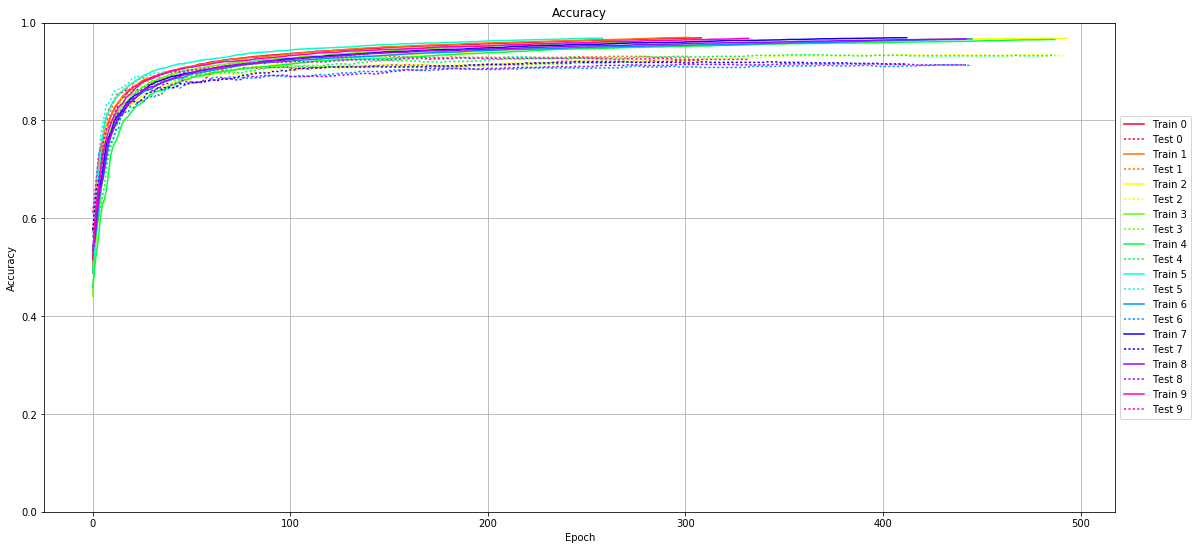

In [14]:
plot_acc(history)

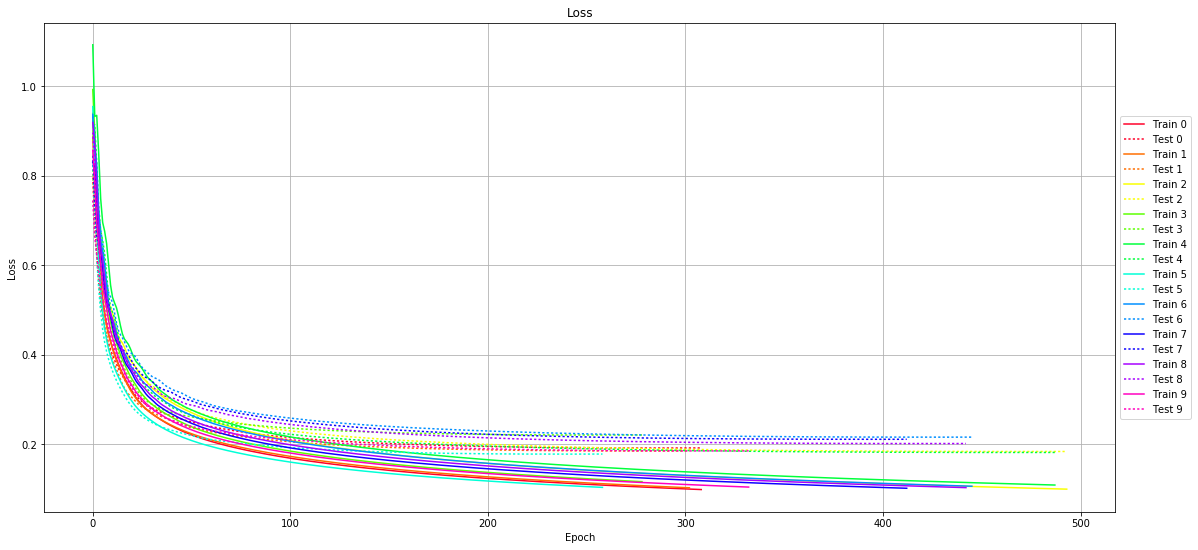

In [15]:
plot_loss(history)

In [16]:
# Viewing the confusion matrix
conf_mat = conf_mat.T  # since rows and cols are interchangeable
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix

Plotting the confusion matrix


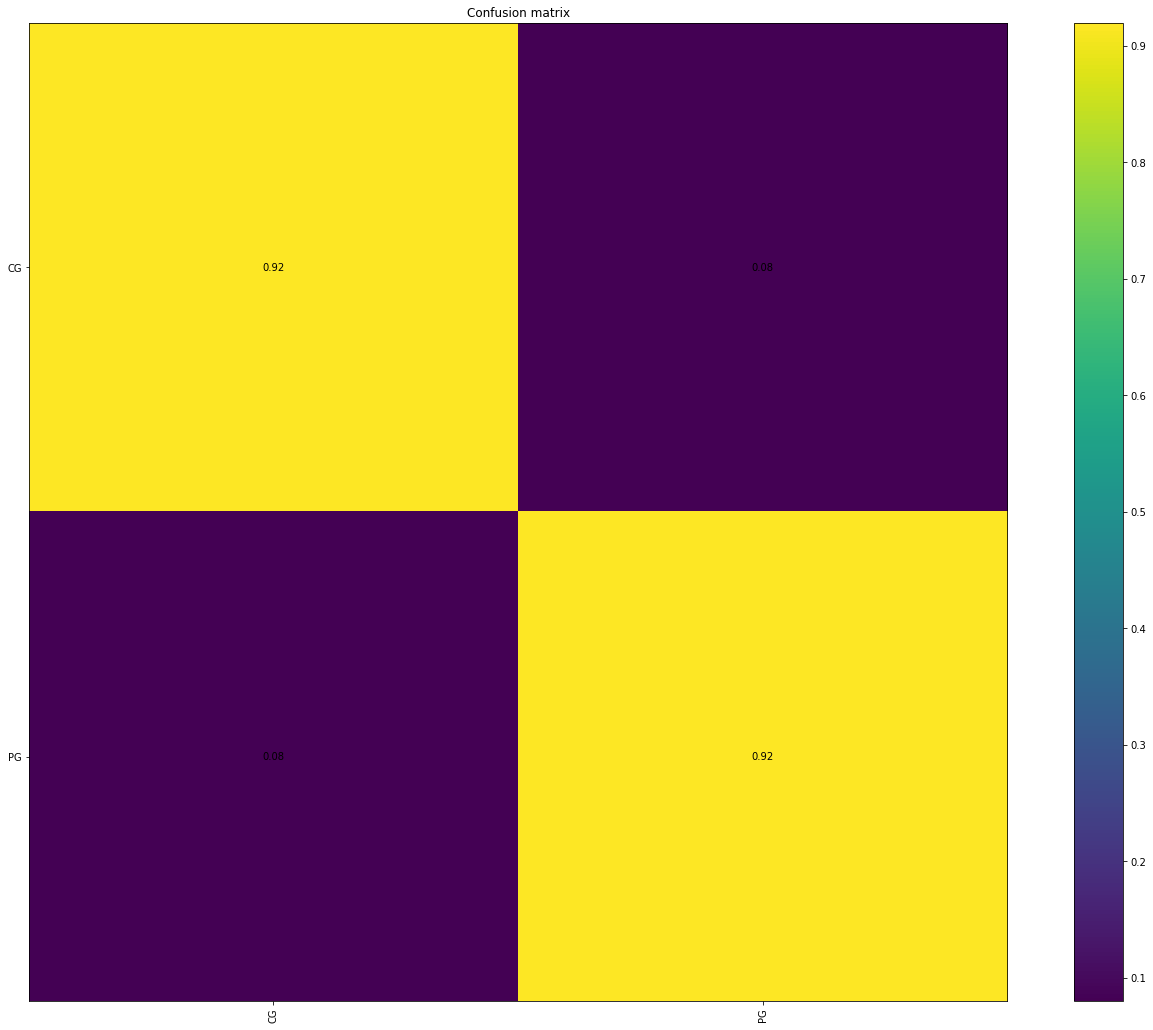

In [17]:
print("Plotting the confusion matrix")
conf_mat = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(24, 18)
plt.imshow(conf_mat,interpolation='nearest')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat[row][col]),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.title('Confusion matrix')
plt.colorbar()
plt.show()